In [18]:
import os
import base64
import openai
import json
import pandas as pd
import requests
from tqdm import tqdm
import openai
from transformers import pipeline
# from openai import OpenAI, AzureOpenAI
from dotenv import load_dotenv
import qa_package.dataclasses.orm as d
from sqlalchemy.engine import Engine, create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy.sql import select

load_dotenv()

API_BASE = os.getenv('API_BASE')
API_KEY = os.getenv('API_KEY')
API_VERSION = os.getenv('API_VERSION')
CHAT_DEPLOYMENT_NAME = os.getenv('CHAT_DEPLOYMENT_NAME')
EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')
NEW_API_KEY = os.getenv('MY_API_KEY')

In [2]:
# openai.api_key = NEW_API_KEY
# openai.api_type = "open_ai"
openai.api_key = API_KEY
openai.api_type = "azure"
openai.api_base = API_BASE
openai.api_version = API_VERSION

In [13]:
CSV_FILE = "/Users/spare/Documents/data/articles.csv"
df = pd.read_csv(CSV_FILE)

- https://help.openai.com/en/articles/7102672-how-can-i-access-gpt-4 (I cannot use this)

#### downloading could not show progress bar
- Run this in terminal `watch du -h  ~/.cache/huggingface/hub `

In [3]:
captioner = pipeline("image-to-text",
        model="Salesforce/blip-image-captioning-base")

<img src="https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png">

In [4]:
captioner(
    "https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png"
)

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'two birds are standing next to each other birds'}]

In [7]:
root_img_path = "/Users/spare/Documents/data/images/"
img_paths = os.listdir(root_img_path)

0554598009.jpg


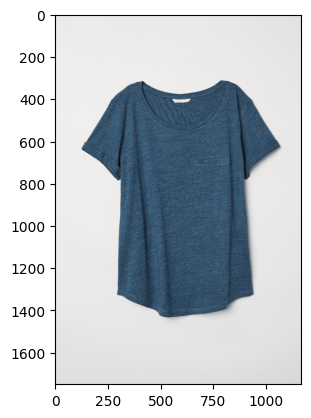

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
tmpimg = mpimg.imread(root_img_path+img_paths[0])
plt.imshow(tmpimg)
print(img_paths[0])

In [12]:
captioner(root_img_path+img_paths[0])

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'the organic linen top in indigo blue'}]

In [16]:
df[df.article_id==int(img_paths[0].replace(".jpg",""))]

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,garment_group_name,detail_desc
157,554598009,Nora T-shirt,T-shirt,Garment Upper body,Melange,Dark Blue,Jersey Basic,"T-shirt in soft jersey with a round neck, shor..."


In [17]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


In [19]:
base64_image = encode_image(root_img_path+img_paths[0])

In [21]:
captioner(base64_image)

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'the organic linen top in indigo blue'}]